# Training a neural network

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Download data and create dataset objects

In [2]:

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

/itf-fi-ml/home/vegarant/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Visualizing the Dataset
We can index Datasets manually like a list: `training_data[index]`.

img.shape:  torch.Size([1, 28, 28])
img.dtype:  torch.float32
img.device:  cpu


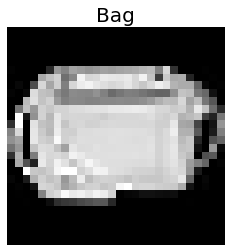

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

sample_idx = 105

img, label = training_data[sample_idx]
print('img.shape: ',  img.shape)
print('img.dtype: ',  img.dtype)
print('img.device: ', img.device) # Notice that the data is lying on the CPU. This is standard.

plt.title(labels_map[label], fontsize=20)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()


## Create dataloaders
The `Dataset` retrieves our dataset’s features and labels one sample at a time. When training a model, we typically want to pass samples in “minibatches” and reshuffle the data at every epoch to reduce model overfitting and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.


In [4]:
# Hyperparameters
shuffle=True
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Example: Iterate through the DataLoader

Input batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


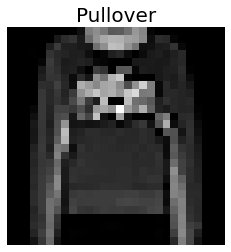

Label: 2


In [5]:
# Display image and label.
train_input, train_labels = next(iter(train_dataloader))
print(f"Input batch shape: {train_input.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_input[0].squeeze()
label = int(train_labels[0])

plt.title(labels_map[label], fontsize=20)
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Create model
We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the forward method.

In [6]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        # Create all the network layers (make sure the dimensions add up)
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.sig1 = nn.Sigmoid()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding='valid')
        self.sig2 = nn.Sigmoid()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120, bias=True)
        self.sig3  = nn.Sigmoid()
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.sig4  = nn.Sigmoid()
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)

    def forward(self, x):
        # Specify how the layers should be connected
        x = self.conv1(x)
        x = self.sig1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.sig2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)     
        x = self.sig3(x)
        x = self.fc2(x)
        x = self.sig4(x)
        logits = self.fc3(x)
        return logits

## Create network instance

In [7]:
model = LeNet()
print(model)


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (sig1): Sigmoid()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (sig2): Sigmoid()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (sig3): Sigmoid()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (sig4): Sigmoid()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Prepare the training

In [8]:
# Define a few hyperparameters
device = torch.device('cuda')
epochs = 5 # Number of iterations with stochastic gradient descent.
learning_rate = 0.003

loss_fn = nn.CrossEntropyLoss() # Define the loss funciton
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Choose the optimizer 
model.to(device) # Move model parameters to the device

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (sig1): Sigmoid()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (sig2): Sigmoid()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (sig3): Sigmoid()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (sig4): Sigmoid()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Define the train loop

Inside the training loop, optimization happens in three steps:
 * Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    
    batch = 0
    for x, y in dataloader:
        # Compute prediction and loss
        batch = batch + 1
        
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad() # A common mistake is to forget to call this function.
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validation_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            
            val_loss += loss_fn(pred, y).item() # This is a float
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Validataion Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

## Start training

In [10]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    validation_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.339809  [ 6400/60000]
loss: 2.306215  [12800/60000]
loss: 2.300541  [19200/60000]
loss: 2.301488  [25600/60000]
loss: 2.304684  [32000/60000]
loss: 2.305489  [38400/60000]
loss: 2.303932  [44800/60000]
loss: 2.302500  [51200/60000]
loss: 2.301720  [57600/60000]
Validataion Error: 
 Accuracy: 10.0%, Avg loss: 2.302619 

Epoch 2
-------------------------------
loss: 2.302803  [ 6400/60000]
loss: 2.299429  [12800/60000]
loss: 2.302235  [19200/60000]
loss: 2.301553  [25600/60000]
loss: 2.306116  [32000/60000]
loss: 2.305631  [38400/60000]
loss: 2.300421  [44800/60000]
loss: 2.299373  [51200/60000]
loss: 2.304207  [57600/60000]
Validataion Error: 
 Accuracy: 10.0%, Avg loss: 2.302794 

Epoch 3
-------------------------------
loss: 2.295568  [ 6400/60000]
loss: 2.307060  [12800/60000]
loss: 2.304696  [19200/60000]
loss: 2.302372  [25600/60000]
loss: 2.303864  [32000/60000]
loss: 2.301644  [38400/60000]
loss: 2.303124  [44800/60000]
loss: 2.3019